In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm 


# Custom Dataset for Medical Images
class OCTDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

# Load data
with open('train_data.pkl', 'rb') as f:
    data = pickle.load(f)

with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

images = np.array(data['images'])  # Grayscale images
labels = np.array(data['labels'])  # Integer labels

test_images = np.array(test_data['images'])

# Train-validation split
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Transformations for preprocessing
transform_train = transforms.Compose([
    transforms.ToPILImage(mode='L'),  # Convert grayscale to PIL
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.ToPILImage(mode='L'),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = OCTDataset(train_images, train_labels, transform=transform_train)
val_dataset = OCTDataset(val_images, val_labels, transform=transform_test)
test_dataset = OCTDataset(test_images, transform=transform_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


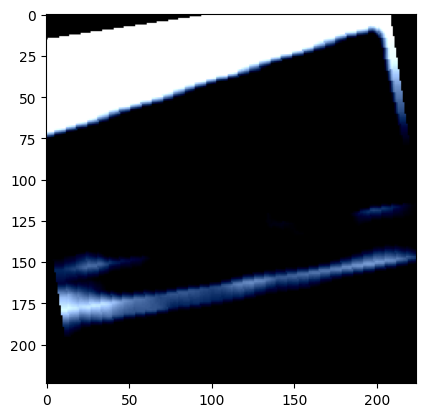

In [3]:
import matplotlib.pyplot as plt

batch_images, batch_labels = next(iter(train_loader))
batch_images[0].size()
plt.imshow(batch_images[1].permute(1, 2, 0))

In [2]:
import torchvision 

device = 'cuda'
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [3]:
import torchvision 

device = 'cuda'
weights = torchvision.models.DenseNet121_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.densenet121(weights=weights).to(device)

In [4]:
import torchvision 

device = 'cuda'
weights = torchvision.models.ResNet18_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.resnet18(weights=weights).to(device)

In [5]:
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.features.parameters():
#     param.requires_grad = False

In [3]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len([0, 1, 2, 3])

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [45]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 4]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [4]:
# Compute class weights
num_classes = len(np.unique(train_labels))  # Determine the number of unique classes
total_samples = len(train_labels)  # Total number of samples

# Count occurrences of each class
class_counts = np.bincount(train_labels)  # Array of counts per class
class_weights = total_samples / (num_classes * class_counts)

# Convert class weights to a tensor and move to GPU if necessary
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).cuda()

print("Class Weights:", class_weights)

Class Weights: [0.7266484  2.38678379 3.13781587 0.53018003]


In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
model.load_state_dict(torch.load("best_model_new_class_weight.pth"))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8\1486862644.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_new_class_weight.pth

<All keys matched successfully>

In [ ]:
# Early stopping
best_val_loss = float('inf')

for epoch in range(5):  # Train for 5 epochs
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.cuda(), labels.cuda()
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.cuda(), labels.cuda()
            labels = labels.long()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    # Calculate average losses
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_new_efficient_new.pth")

# Load the best model
model.load_state_dict(torch.load("best_model_new_efficient_new.pth"))

EfficientNet (V0)
100%|██████████| 610/610 [1:03:29<00:00,  6.25s/it]
100%|██████████| 153/153 [03:01<00:00,  1.19s/it]
Epoch 1, Train Loss: 0.5562, Validation Loss: 0.4489
100%|██████████| 610/610 [55:54<00:00,  5.50s/it] 
100%|██████████| 153/153 [02:34<00:00,  1.01s/it]
Epoch 2, Train Loss: 0.4271, Validation Loss: 0.4519
100%|██████████| 610/610 [56:29<00:00,  5.56s/it]  
100%|██████████| 153/153 [02:32<00:00,  1.00it/s]
Epoch 3, Train Loss: 0.3925, Validation Loss: 0.3967
100%|██████████| 610/610 [55:26<00:00,  5.45s/it]
100%|██████████| 153/153 [02:32<00:00,  1.00it/s]
Epoch 4, Train Loss: 0.3662, Validation Loss: 0.3704
100%|██████████| 610/610 [55:23<00:00,  5.45s/it]
100%|██████████| 153/153 [02:32<00:00,  1.00it/s]
Epoch 5, Train Loss: 0.3424, Validation Loss: 0.3646

In [56]:
validation_predictions = []
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.cuda(), labels.cuda()
        labels = labels.long()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get class predictions

        # Collect predictions and labels
        validation_predictions.extend(preds.cpu().numpy())

100%|██████████| 153/153 [04:12<00:00,  1.65s/it]


In [24]:
from sklearn.metrics import classification_report

print(classification_report(val_labels, validation_predictions))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      6655
           1       0.88      0.94      0.91      2045
           2       0.48      0.79      0.60      1541
           3       0.96      0.89      0.92      9255

    accuracy                           0.90     19496
   macro avg       0.83      0.88      0.84     19496
weighted avg       0.92      0.90      0.90     19496



In [54]:
test_predictions = []
with torch.no_grad():
    for images in tqdm(test_loader):
        images = images.cuda()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get class predictions
        # Collect predictions and labels
        test_predictions.extend(preds.cpu().numpy())

100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


In [55]:
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'ID': range(1, len(test_predictions) + 1),
    'Label': test_predictions
})

# Save the DataFrame to a CSV file
df.to_csv('efficientnet_balance_long_training.csv', index=False)

print("CSV file created successfully.")

CSV file created successfully.
